## Notebook to train a 2d U-net model for binary segmentation of maternal and foetal blood volumes

Elements of this notebook are based upon training material from the fastai course - Practical Deep Learning for Coders (https://course.fast.ai/). Specifically the camvid tutorial which can be found here (https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb).

#### Imports

In [5]:
import os
from datetime import date
import numpy as np
import dask.array as da
import h5py as h5
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch.nn.functional as F
from skimage import img_as_ubyte, io, exposure, img_as_float
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#### Helper functions

In [6]:
def da_from_data(path):
    """Returns a dask array when given a path to an HDF5 file.
    
    The data is assumed to be found in '/data' in the file.
    
    Args:
        path (Path): The path to the HDF5 file.

    Returns:
        dask.array: A dask array object for the data stored in the HDF5 file."""
    
    f = h5.File(path, 'r')
    d = f['/data']
    return da.from_array(d, chunks='auto')

def output_im(data, path, offset, crop_val, normalize=False, label=False):
    """Converts a slice of data into an image on disk.
    
    Args:
        data (numpy.array): The data slice to be converted.
        path (str): The path of the image file including the filename prefix.
        offset (int): An integer offset starting value for cropping the array or None.
        crop_val (int): An integer end value for cropping the array or None.
        normalize (bool): Whether to perform data clipping and rescaling to uint8.
        label (bool): Whether to convert values >1 to 1."""

    if normalize:
        data_st_dev = np.std(data)
        data_mean = np.mean(data)
        clip_limit = data_st_dev * 3 # 99.7% of values within 3 stdevs
        lower_bound = data_mean - clip_limit
        upper_bound = data_mean + clip_limit
        data = np.clip(data, lower_bound, upper_bound)
        data = exposure.rescale_intensity(data, out_range='float')
        data = img_as_ubyte(data)
    if label:
        data[data > 1] = 1
    # Crop the image
    if offset or crop_val:
        data = data[offset:crop_val, offset:crop_val]
    io.imsave(f'{path}.png', data)
    
def output_slices_to_disk(axis, data, output_path, name_prefix, offset, crop_val, normalize=False, label=False):
    """Coordinates the slicing of an image volume in one or all of the three orthogonal
    planes to images on disk. 
    
    Args:
        axis (string): Which plane to slice the data in. Either 'x', 'y, 'z' or 'all'.
        data (array): The data volume to be sliced.
        output_path (Path): A Path object to the output directory.
        name_prefix (str): An string to prepend to the output filenames, normally 'data' or 'seg'.
        offset (int): An integer offset starting value for cropping the array or None.
        crop_val (int): An integer end value for cropping the array or None.
        normalize (bool): Whether to perform data clipping and rescaling to uint8.
        label (bool): Whether to convert values >1 to 1."""
    
    shape_tup = data.shape
    if axis in ['z', 'all']:
        print('Outputting z stack')
        for val in range(shape_tup[0]):
            out_path = output_path/f"{name_prefix}_z_stack_{val}"
            output_im(data[val, :, :], out_path, offset, crop_val, normalize, label)
    if axis in ['x', 'all']:
        print('Outputting x stack')
        for val in range(shape_tup[1]):
            out_path = output_path/f"{name_prefix}_x_stack_{val}"
            output_im(data[:, val, :], out_path, offset, crop_val, normalize, label)
    if axis in ['y', 'all']:
        print('Outputting y stack')
        for val in range(shape_tup[2]):
            out_path = output_path/f"{name_prefix}_y_stack_{val}"
            output_im(data[:, :, val], out_path, offset, crop_val, normalize, label)
    if axis not in ['x', 'y', 'z', 'all']:
        print("Axis should be one of: [all, x, y, or z]!")

### Step 1: Load in the HDF5 files with the 384 x 384 x 384 training data volume and the corresponding volume of labels

- Define a string **data_path** - the path to the data volume hdf5 file
- Define a string **seg_path** - the path to the segmentation volume hdf5 file

In [7]:
data_path = "/home/vvw07985/dls_user/201019_files_for_placenta_repo/placental-segmentation-2dunet/maternal_fetal_blood_volumes/training_data/tissue_384cube_zyx_310-694_1242-1626_510-894_DATA.h5"
seg_path = "/home/vvw07985/dls_user/201019_files_for_placenta_repo/placental-segmentation-2dunet/maternal_fetal_blood_volumes/training_data/tissue_384cube_zyx_310-694_1242-1626_510-894_LABELS.h5"

In [8]:
# Convert the paths to Path objects
data_path = Path(data_path)
seg_path = Path(seg_path)

In [9]:
# Load in the data volume
data_vol = da_from_data(data_path)
data_vol

dask.array<array, shape=(384, 384, 384), dtype=uint8, chunksize=(384, 384, 384), chunktype=numpy.ndarray>

In [10]:
# Load in the label volume
seg_vol = da_from_data(seg_path)
seg_vol

dask.array<array, shape=(384, 384, 384), dtype=uint8, chunksize=(384, 384, 384), chunktype=numpy.ndarray>

### Step 2: Slice the data volume and label volume in the 3 planes parallel to the *xy*, *xz* and *yz* planes and output the slices to disk

- Define a string **data_out** - the path to a directory to store the data slices
- Define a string **seg_out** - the path to a directory to store the segmentation slices

In [ ]:
data_out = "path/to/a/directory/for/the/data/slices"
seg_out = "path/to/a/directory/for/the/segmentation/slices"
# Convert the paths to Path objects
data_out = Path(data_out)
seg_outPath(seg_out)

In [55]:
# Output the normalised data slices - set normalize = False since this data has already been normalised
output_slices_to_disk('all', data_vol, data_out, 'data', None, None, normalize=False)

Outputting z stack
Outputting x stack
Outputting y stack


In [56]:
# Output the seg slices - since these have the labels [0, 255] we set label=True to convert to [0, 1] 
output_slices_to_disk('all', seg_vol, seg_out, 'seg', None, None, label=True)

Outputting z stack
Outputting x stack
Outputting y stack


### Step 3: Create datasets from the directories of image slices

#### More helper functions

In [57]:
# Since we're doing binary segmentation, we need to define a binary label list class
class BinaryLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn)

class BinaryItemList(SegmentationItemList):
    _label_cls = BinaryLabelList

In [ ]:
# Get the data filenames
fnames = get_image_files(data_out)
# Get the segmentation filenames
lbl_names = get_image_files(seg_out)

In [ ]:
# lambda function to convert between data and segmentation filenames
get_y_fn = lambda x: seg_out/f'{"seg" + x.stem[4:]}{x.suffix}'

In [ ]:
# Choose a batchsize dependant on how much GPU memory is available
free = gpu_mem_get_free_no_cache()
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
# Set names of the label classes in the segmentation
codes = np.array(['maternal', 'foetal'])

Here we create the training and validation sets with a standard set of image augmentation transforms

In [60]:
src = (BinaryItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(), size=256, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

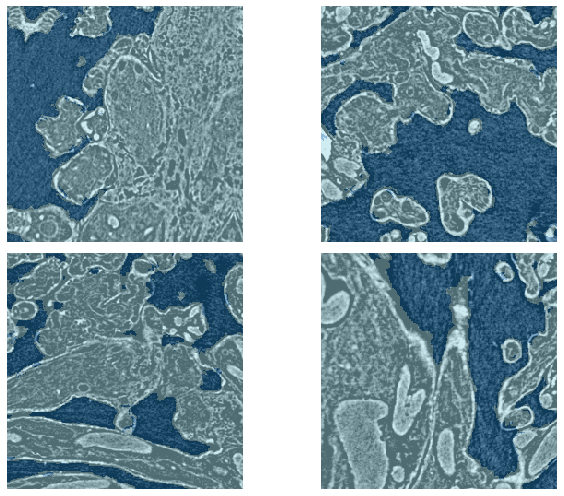

In [61]:
# Show a random batch of images from the training dataset overlayed with the corresponding segmentation
data.show_batch(2, figsize=(10,7))

### Step 4: Create a unet model that is linked to the dataset

#### More helper functions

In [ ]:
# Create a metric for assessing performance
metrics=[partial(dice, iou=True)]

# weight decay 
wd=1e-2

def bce_loss(logits, labels):
    """Defines the binary cross entropy loss function used when training a U-net on binary data."""
    logits=logits[:,1,:,:].float()
    labels = labels.squeeze(1).float()
    return F.binary_cross_entropy_with_logits(logits, labels)

In [62]:
# Create the U-net learner object with pretrained resnet 34 encoder
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, loss_func=bce_loss)

### Step 5: Find a learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


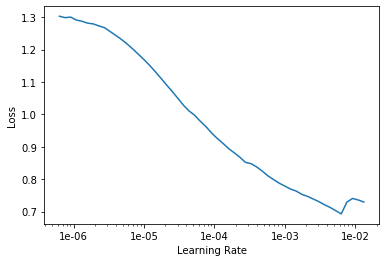

In [63]:
lr_find(learn)
learn.recorder.plot()

In [64]:
# Define the learning rate here
lr=slice(1e-5, 1e-3)

### Step 6: Train the U-net on the data

In [65]:
learn.fit_one_cycle(10, lr, pct_start=0.5)

epoch,train_loss,valid_loss,dice,time
0,0.254599,0.182242,0.111720,00:28
1,0.175100,0.145757,0.677492,00:26
2,0.153537,0.126383,0.818004,00:26
3,0.139042,0.122146,0.887048,00:25
4,0.131126,0.115474,0.910686,00:26
5,0.123162,0.113911,0.923519,00:26
6,0.114988,0.109049,0.920883,00:26
7,0.111451,0.104987,0.935691,00:26
8,0.106146,0.101505,0.932422,00:25
9,0.102830,0.100447,0.928139,00:25


In [66]:
# Save the weights 
learn.save('stage-1')

### Step 7: Unfreeze the U-net and perform more rounds of training

In [67]:
# Unfreeze all the trainable layers in the model for fine tuning
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


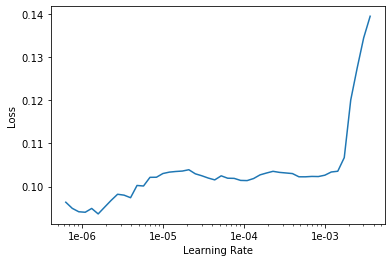

In [68]:
# Find the learning rate of the unforzen model
lr_find(learn)
learn.recorder.plot()

In [69]:
lr=slice(1e-5, 1e-4)

In [70]:
learn.fit_one_cycle(5, lr, pct_start=0.4)

epoch,train_loss,valid_loss,dice,time
0,0.102045,0.100153,0.928466,00:27
1,0.102797,0.100006,0.924308,00:27
2,0.102461,0.098248,0.931001,00:27
3,0.099479,0.096965,0.926490,00:27
4,0.098688,0.096550,0.929091,00:27


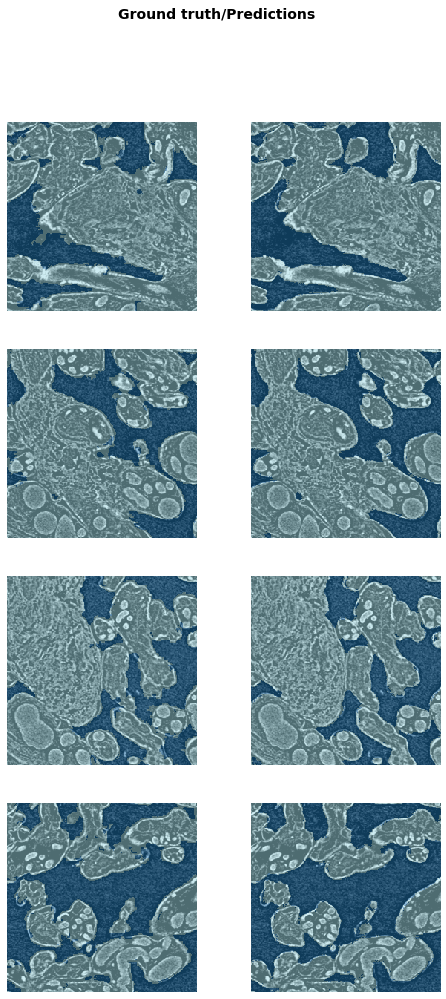

In [71]:
# Show a random batch of ground truth images and the corresponding predictions
learn.show_results(rows=4)

### Step 8: Save the trained U-net model

- Define a string **output_directory** - the path to a directory where you would like to store the model

In [ ]:
output_directory = "path/to/some/directory"
output_directory = Path(output_directory)

In [72]:
# save the model
learn.export(output_directory/'placental_vessels_384_trainedUnet256.pkl')